In [2]:
from __future__ import print_function
import numpy as np 
import pandas as pd 
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
import IPython.display as ipd
import seaborn as sns
import warnings
import os
import torch
from torch import nn, optim
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing

In [108]:
audio_features = pd.read_pickle('/home/achharia/Domain-adaptation/domain_adaptation/LSTM-DENSE/speech-emotion-recognition-iemocap/preprocess_info/feature_vectors.pkl')

In [109]:
type(audio_features)

dict

In [110]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'exc': 2,
                'sad': 3,
                'fru': 4,
                'fea': 5,
                'sur': 6,
                'neu': 7,
                'xxx': 8,
                'oth': 8,
                'dis': 8}

In [111]:
audio_features.keys()

dict_keys(['wav_file', 'label', 'mfccs', 'spec_db'])

In [112]:
audio_features['mfccs'][0].shape


(13, 84)

In [115]:
b=[]
for i in range(len(audio_features['mfccs'])):
    a=audio_features['mfccs'][i].shape[1]
    b.append(a)
len(b)

10039

In [117]:
c=[]
for i in range(len(audio_features['label'])):
    a=audio_features['label'][i]
    c.append(a)
len(c)

10039

In [131]:
labelsl = []
mfccsl = []
spec_dbl = []
for i in range(len(audio_features['label'])):
    if (audio_features['label'][i]) in [0, 1, 3, 7]:
        labelsl.append(audio_features['label'][i])
        mfccsl.append(audio_features['mfccs'][i])
        spec_dbl.append(audio_features['spec_db'][i])

In [132]:
len(mfccsl)

4490

In [133]:
f=[]
for i in range(len(mfccsl)):
    a = mfccsl[i].shape[1]
    f.append(a)
np.median(np.array(f))

152.0

In [134]:
#num=160
#padd=num-119
#padd=padd/2
#padd=padd+1
#a=np.pad(np.array(mfccsl[0]),[(0,0),(int(padd),int(padd))],mode='constant')
#garbage=a[:,:num]
#garbage.shape

finalmfccs = []
for i in range(len(mfccsl)):
    a = mfccsl[i]
    if a.shape[1]<num:
        padd = num - a.shape[1]
        padd = padd / 2
        padd = padd + 1
        a = np.pad(np.array(a), [(0,0), (int(padd), int(padd))], mode = 'constant')
    garbage = a[:, :num]
    finalmfccs.append(garbage)

In [135]:
np.array(finalmfccs).shape

(4490, 13, 160)

In [138]:
for i in range(len(labelsl)):
    if labelsl[i] == 3:
        labelsl[i] = 2
    if labelsl[i] == 7:   # Neutral
        labelsl[i] = 3
# 0 is anger, 1 is happiness, 3 is sadness, 7 is neutral
# Updated 0 is anger, 1 is happiness, 2 is sadness and 3 is neutral

In [139]:
Counter(labelsl)

Counter({3: 1708, 0: 1103, 2: 1084, 1: 595})

In [140]:
print(np.array(finalmfccs).shape)     # The Final Pre-processed MFCCS
print(len(labelsl))                   # The Final Labels

(4490, 13, 160)
4490


In [141]:
X_train, X_test, y_train, y_test = train_test_split(finalmfccs, labelsl, test_size=0.2)

## Manually splitting
#dataset_split_ratio = int(len(labelsl) * 0.80) 
#train_finalmfccs = finalmfccs[:dataset_split_ratio]
#train_finallabels = labelsl[:dataset_split_ratio]
#print(np.array(train_finalmfccs).shape)
#
#test_finalmfccs = finalmfccs[dataset_split_ratio:]
#test_finallabels = labelsl[dataset_split_ratio:]
#print(np.array(test_finalmfccs).shape)

In [142]:
Counter(y_train)

Counter({3: 1381, 0: 875, 2: 857, 1: 479})

In [143]:
Counter(y_test)

Counter({3: 327, 2: 227, 0: 228, 1: 116})

In [144]:
batch_size = 128

In [147]:
class AudioDataset_train(Dataset):
    """
    IEMOCAP Dataset
    """
    def __init__(self):
        self.len = len(X_train)
        self.x_data = torch.from_numpy(np.array(X_train))
        self.y_data = torch.from_numpy(np.array(y_train))
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len
    
traindataset = AudioDataset_train()

trainloader = DataLoader(dataset = traindataset,
                         batch_size = batch_size,
                         shuffle = True)

In [148]:
class AudioDataset_test(Dataset):
    """
    Diabetes Dataset
    """
    
    def __init__(self):
        self.len = len(X_test)
        self.x_data = torch.from_numpy(np.array(X_test))
        self.y_data = torch.from_numpy(np.array(y_test))
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len
    
testdataset = AudioDataset_test()
testloader = DataLoader(dataset = testdataset,
                        batch_size = batch_size)

In [149]:
len(testloader)

8

In [150]:
testiter = iter(testloader)
features, labels = next(testiter)
features.shape, labels.shape

(torch.Size([128, 13, 160]), torch.Size([128]))

In [151]:
features.type()

'torch.FloatTensor'

In [208]:
keep_prob = 0.5

In [209]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 224, 224, 3)
        #    Conv     -> (?, 224, 224, 16)
        #    Pool     -> (?, 112, 112, 16)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 112, 112, 16)
        #    Conv      ->(?, 112, 112, 32)
        #    Pool      ->(?, 56, 56, 32)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 ImgIn shape=(?, 56, 56, 32)
        #    Conv      ->(?, 56, 56, 64)
        #    Pool      ->(?, 28, 28, 64)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        
        # L4 ImgIn shape=(?, 28, 28, 64)
        #    Conv      ->(?, 28, 28, 16)
        #    Pool      ->(?, 14, 14, 16)
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 16, kernel_size=1, stride=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))

        # L4 FC 14x14x16 inputs -> 512 outputs
        self.fc1 = torch.nn.Linear(14 * 14 * 16, 512, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
#         self.layer4 = torch.nn.Sequential(
#             self.fc1,
#             torch.nn.ReLU(),
#             torch.nn.Dropout(p=1 - keep_prob))
        # L5 Final FC 1024 inputs -> 512 outputs
        
        self.fc2 = torch.nn.Linear(512, 4, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters
        # L6 Final FC 512 inputs -> 4 outputs
#         self.fc3 = torch.nn.Linear(512, 4, bias=True)
#         torch.nn.init.xavier_uniform_(self.fc3.weight) # initialize parameters

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
#         print(out.size())
        out = out.view(out.size(0), -1)
#         print(out.size())# Flatten them for FC
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
#         out = self.fc3(out)
        return out


In [242]:
class DiagonalLinear(nn.Module):
    def __init__(self, input_size, output_size):
        super(DiagonalLinear, self).__init__()
        self.weight = nn.Parameter(torch.ones(output_size, input_size))
        # Set non-diagonal elements to be constant
        with torch.no_grad():
            self.weight.fill_diagonal_(1)
            for i in range(input_size):
                for j in range(output_size):
                    if i != j:
                        self.weight[j, i] = 0.0
                        self.weight[j, i].requires_grad = False

    def forward(self, x):
        return torch.matmul(x,self.weight) 



# Define the scaling network
import torch.nn as nn

class Crude_Diag(nn.Module):
    def __init__(self, in_features):
        super(Crude_Diag, self).__init__()
        
        # Set a fixed seed for reproducibility
        torch.manual_seed(0)
        
        # Initialize scaling factors and weight matrix
        scaling_factors = torch.rand(in_features)
        weight = torch.diag(scaling_factors)
        
        # Modify weight matrix to set non-diagonal elements to zero
        with torch.no_grad():
            for i in range(in_features):
                for j in range(in_features):
                    if i != j:
                        weight[i, j] = 0.0
                        weight[i, j].requires_grad = False
        
        # Define linear layer with diagonal weight matrix
        self.linear = nn.Linear(in_features, in_features, bias=False)
        self.linear.weight = nn.Parameter(weight)
        
    def forward(self, x):
        x = self.linear(x)
        return x

class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 224, 224, 3)
        #    Conv     -> (?, 224, 224, 16)
        #    Pool     -> (?, 112, 112, 16)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 112, 112, 16)
        #    Conv      ->(?, 112, 112, 32)
        #    Pool      ->(?, 56, 56, 32)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 ImgIn shape=(?, 56, 56, 32)
        #    Conv      ->(?, 56, 56, 64)
        #    Pool      ->(?, 28, 28, 64)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        
        # L4 ImgIn shape=(?, 28, 28, 64)
        #    Conv      ->(?, 28, 28, 16)
        #    Pool      ->(?, 14, 14, 16)
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 16, kernel_size=1, stride=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))

        # L4 FC 14x14x16 inputs -> 512 outputs
        self.fc1 = torch.nn.Linear(14 * 14 * 16, 512, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
#         self.layer4 = torch.nn.Sequential(
#             self.fc1,
#             torch.nn.ReLU(),
#             torch.nn.Dropout(p=1 - keep_prob))
        # L5 Final FC 1024 inputs -> 512 outputs
        
        # Affine Layer
        self.Diag_Affine = Crude_Diag(512)
        self.test_linear = torch.nn.Linear(512,512)
        self.fc2 = torch.nn.Linear(512, 4, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters
        # L6 Final FC 512 inputs -> 4 outputs
#         self.fc3 = torch.nn.Linear(512, 4, bias=True)
#         torch.nn.init.xavier_uniform_(self.fc3.weight) # initialize parameters

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
#         print(out.size())
        out = out.view(out.size(0), -1)
#         print(out.size())# Flatten them for FC
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.Diag_Affine(out)
        # out = self.test_linear(out)
        out = self.fc2(out)
#         out = self.fc3(out)
        return out
    


In [243]:
# Create an instance of the scaling network
scale_net = Crude_Diag(4)
# scale_net = DiagonalLinear(4,4)

# Scale some input data
input = torch.tensor([[1.0, 2.0, 3.0,4.0]])
scaled_input = scale_net(input)
# scaled_input = scale_net(input)

# Print the scaled input
print(scaled_input)

tensor([[0.4963, 1.5364, 0.2654, 0.5281]], grad_fn=<MmBackward0>)


In [244]:
model = CNN()
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)     

print("network before turning off sparse layer", count_parameters(model))

for param in model.Diag_Affine.parameters():
    param.requires_grad = False     
print("network after turning off sparse layer", count_parameters(model))
model = CNN()

network before turning off sparse layer 2157332
network after turning off sparse layer 1895188


In [245]:
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (fc1): Linear(in_features=3136, out_featur

In [235]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [236]:
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model = model.to(device)

In [237]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

2,157,620 total parameters.
2,157,620 training parameters.


In [238]:
def plot_confusion_matrix(actual, predicted, labels):
    cm = confusion_matrix(actual, predicted, labels)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, annot_kws={"size": 10}, fmt='.0f'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
    plt.show()

In [219]:
anger = 0
happiness = 0
sadness = 0
neutral = 0

for _, target in trainloader:
    labels = list(target.numpy())
    anger += len([x for x in labels if x == 0])
    happiness += len([x for x in labels if x == 1])
    sadness += len([x for x in labels if x == 2])
    neutral += len([x for x in labels if x == 3])
    
for _, target in testloader:
    labels = list(target.numpy())
    anger += len([x for x in labels if x == 0])
    happiness += len([x for x in labels if x == 1])
    sadness += len([x for x in labels if x == 2])
    neutral += len([x for x in labels if x == 3])

In [220]:
print("anger {} happiness {} sadness {} neutral {}".format(anger, happiness, sadness, neutral))

anger 1103 happiness 595 sadness 1084 neutral 1708


In [221]:
sample_weights = [1/anger, 1/happiness, 1/sadness, 1/neutral]
class_weights = torch.FloatTensor(sample_weights).cuda()
print(class_weights)

tensor([0.0009, 0.0017, 0.0009, 0.0006], device='cuda:0')

In [222]:
label_to_class = {0: 'anger', 1: 'happiness', 2: 'sadness', 3: 'neutral'}
final_labels = ['anger', 'happiness', 'sadness', 'neutral']

In [ ]:
# instantiation
model = CNN()
print("network after turning off sparse layer", count_parameters(net))

network after turning off sparse layer 57554


In [225]:
device='cuda'
model.to(device)

Net(
  (l1): Linear(in_features=160, out_features=200, bias=True)
  (l2): Linear(in_features=200, out_features=100, bias=True)
  (l3): Linear(in_features=100, out_features=50, bias=True)
  (sparse): Crude_Diag(
    (linear): Linear(in_features=50, out_features=50, bias=False)
  )
  (l5): Linear(in_features=50, out_features=4, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [227]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [228]:
# optimizer and criterion
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.003)
optimizer = optim.Adam(model.parameters(), lr=0.003)
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [246]:
def train(epoch, model):
    model.train()
    correct_train = 0
    train_loss = 0
    train_acc = 0
    
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        print(data.shape)
        
        # zero the gradient, forward, backward and running pytorch rhythm
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        # get the label of prediction
        pred = torch.max(output.data, 1)[1]
        correct_train += pred.eq(target.data.view_as(pred)).cpu().sum()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\n'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
    
    train_loss /= len(trainloader.dataset)
    train_acc = 100. * correct_train / len(trainloader.dataset)
    print('\nTrain set: Average loss: {:.4f}\n'.format(train_loss))
    print('\nTrain Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct_train, len(trainloader.dataset), 100. * correct_train / len(trainloader.dataset)))
    
    return train_loss, int(train_acc.numpy())
            

In [247]:
from sklearn.metrics import confusion_matrix
def test(model):
    model.eval()
    test_loss = 0
    test_acc = 0
    correct = 0
    history_test = []

    pred_model = []
    actual = []

    for data, target in testloader:
        data, target = data.to(device), target.to(device)

        # output from model
        output = model(data)

        # sum total loss
        test_loss += criterion(output, target).item()

        # get the label of prediction
        pred = torch.max(output.data, 1)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        pred_model.append(pred.cpu().numpy())
        actual.append(target.data.cpu().numpy())


    test_loss /= len(testloader.dataset)
    test_acc = 100. * correct / len(testloader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))


    pred_with_label = [label_to_class[label] for label in list(np.concatenate(pred_model))]
    actual_with_label = [label_to_class[label] for label in list(np.concatenate(actual))]

    confusion_matrix(actual_with_label, pred_with_label, labels=final_labels)

    print('\n Classification Report \n {} \n'.format(classification_report(actual_with_label, pred_with_label)))

    return test_loss, int(test_acc.numpy())

In [248]:
history, n_epoch = [], 101

for epoch in range(1, n_epoch):    
    # exp_lr_scheduler.step(epoch)
    # import pdb
    # pdb.set_trace()
    train_loss, train_acc = train(epoch, model)
    test_loss, test_acc = test(model)
    
    # plateau_scheduler.step(test_loss)
    history.append([train_loss, train_acc, test_loss, test_acc])

torch.Size([128, 13, 160])


RuntimeError: Given groups=1, weight of size [16, 1, 3, 3], expected input[1, 128, 13, 160] to have 1 channels, but got 128 channels instead

In [202]:
history_df = pd.DataFrame(history, columns=["train_loss", "train_acc", "test_loss", "test_acc"])
history_df["epoch"] = [x for x in range(1, n_epoch)]
print(history_df)

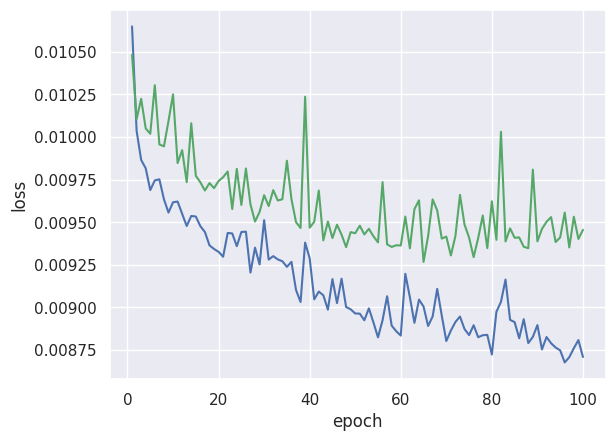

In [50]:
sns.set()
sns.lineplot(x='epoch', y='train_loss', data=history_df, color='b')
# plt.xticks(history_df.epoch)
sns.lineplot(x='epoch', y='test_loss', data=history_df, color='g')
plt.ylabel("loss")
plt.show()

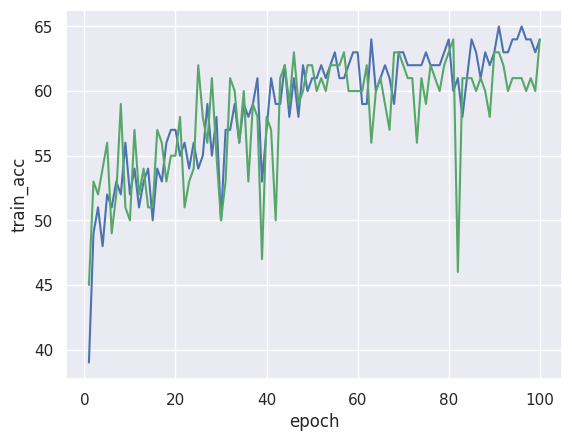

In [51]:
sns.set()
sns.lineplot(x='epoch', y='train_acc', data=history_df, color='b')
# plt.xticks(history_df.epoch)
sns.lineplot(x='epoch', y='test_acc', data=history_df, color='g')
plt.show()